In [1]:
from RLWK.rlwk import Rlwk
import pandas as pd
import numpy as np
import os
import scipy.io
from sklearn.metrics import normalized_mutual_info_score,adjusted_rand_score
from sklearn.cluster import KMeans
from coclust.clustering.spherical_kmeans import SphericalKmeans

from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import re
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

## Import data

In [3]:
"""
tfidf 
    * CLASSIC3 | OHSCALE | CSTR | CLASSIC4  | TR45 | SPORTS
    * BBC | NG5 | NG20 
"""
data_type = 'tfidf' 
data_name = 'CSTR'

# Load dict file
mat = scipy.io.loadmat(os.path.join('new_data', data_type,data_name))

# Load labels
y = mat['labels'].flatten()
mat = mat['mat'].toarray()
k = len(set(y))

print('Shape :',mat.shape)
print('k :',k)


Shape : (475, 1000)
k : 4


__Simple usage of R-Lwk__

In [4]:
lamb = 0.0001
alpha = 0
beta = 3
scale = 0
spher = 1
n = 15
init = 's'

res_nmi, res_ari = [],[]
silh, p2 = [],[]

for i in range(n):
    print('Iteration',i+1,'/',n,end="\r")
    rlwk = Rlwk(k, lambda_val=lamb, alpha=alpha, beta=beta, spher=spher, scale=scale, init = init)
    rlwk.fit(mat, verbose=0)
    
    res_nmi += [normalized_mutual_info_score(rlwk.labels_,y)]
    res_ari += [adjusted_rand_score(rlwk.labels_,y)]

    silh.append(silhouette_score(mat, rlwk.labels_))

best_nmi = [i[0] for i in sorted(zip(res_nmi, silh), key=lambda x: x[1], reverse=True)][:5]
best_ari = [i[0] for i in sorted(zip(res_ari, silh), key=lambda x: x[1], reverse=True)][:5]

print(f'Top 5 results :  \nNMI: {np.mean(best_nmi):.2f} +/- {np.std(best_nmi):.2f} \nARI: {np.mean(best_ari):.2f} +/- {np.std(best_ari):.2f}')
print(f'Mean \nNMI: {np.mean(res_nmi):.2f} +/- {np.std(res_nmi):.2f} \nARI: {np.mean(res_ari):.2f} +/- {np.std(res_ari):.2f}')

Top 5 results :  
NMI: 0.77 +/- 0.02 
ARI: 0.81 +/- 0.02
Mean 
NMI: 0.73 +/- 0.04 
ARI: 0.76 +/- 0.05


### Test skmeans

In [5]:
### skmean
n = 15
res_nmi, res_ari, silh = [],[],[]
for i in range(n):
    print('Iteration',i+1,'/',n,end="\r")
    mat = mat #mat_supp mat_tfidf.toarray()
    sk = SphericalKmeans(n_clusters=k, n_init=20)
    sk.fit(mat)
    res_nmi += [normalized_mutual_info_score(sk.row_labels_,y)]
    res_ari += [adjusted_rand_score(sk.row_labels_,y)]

# Best mean
print(f'\nMean \nNMI: {np.mean(res_nmi):.2f} +/- {np.std(res_nmi):.2f} \nARI: {np.mean(res_ari):.2f} +/- {np.std(res_ari):.2f}')

Iteration 15 / 15
Mean 
NMI: 0.70 +/- 0.04 
ARI: 0.71 +/- 0.07


### Test k-means

In [6]:
n = 15
res_nmi, res_ari = [],[]
for i in range(n):
    print('Iteration',i+1,'/',n,end="\r")
    mat = mat#.toarray() #mat_supp mat_tfidf.toarray()
    kmeans = KMeans(n_clusters=k, n_init=20).fit(mat)
    res_nmi += [normalized_mutual_info_score(kmeans.labels_,y)]
    res_ari += [adjusted_rand_score(kmeans.labels_,y)]

# Best mean
print(f'\nMean \nNMI: {np.mean(res_nmi):.2f} +/- {np.std(res_nmi):.2f} \nARI: {np.mean(res_ari):.2f} +/- {np.std(res_ari):.2f}')

Iteration 15 / 15
Mean 
NMI: 0.62 +/- 0.02 
ARI: 0.52 +/- 0.03


## <span style="color:Red">Analysis</span>### I. Weights

{'whiskers': [<matplotlib.lines.Line2D at 0x29a09564340>,
 'caps': [<matplotlib.lines.Line2D at 0x29a095648e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x29a09564070>],
 'medians': [<matplotlib.lines.Line2D at 0x29a09564e80>],
 'fliers': [<matplotlib.lines.Line2D at 0x29a09565150>],
 'means': []}

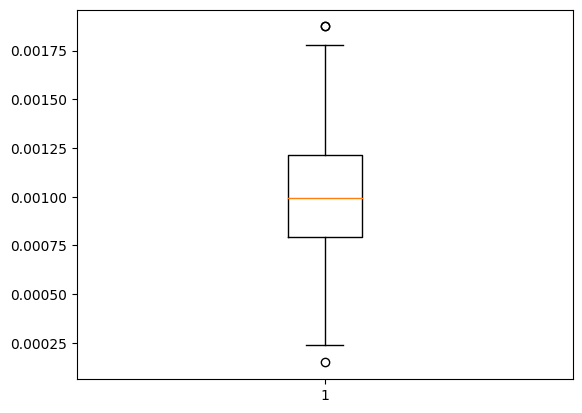

In [7]:
from collections import Counter
import matplotlib.pyplot as plt

lab = rlwk.labels_
pd.DataFrame(rlwk.weights_).describe()
plt.boxplot(rlwk.weights_)

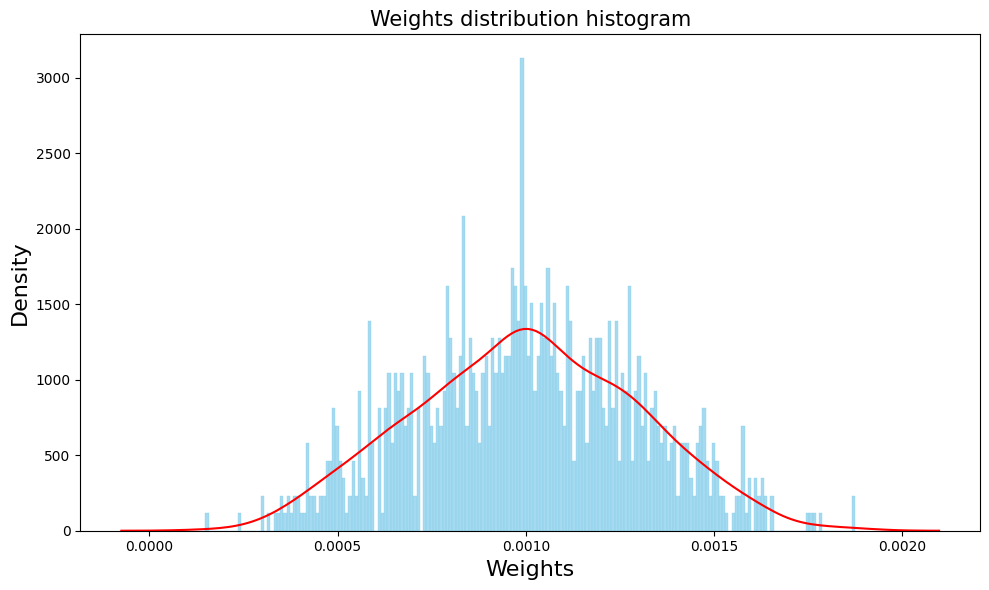

In [8]:
weights = rlwk.weights_
plt.figure(figsize=(10, 6))

# Histogramme
sns.histplot(weights, bins=200, kde=False, stat='density', color='skyblue', edgecolor='skyblue')
sns.kdeplot(weights, color='red')
plt.title('Weights distribution histogram', fontsize=15)
plt.xlabel('Weights', fontsize=16)
plt.ylabel('Density', fontsize=16)


# Ajustement des graphiques
plt.tight_layout()
plt.show()

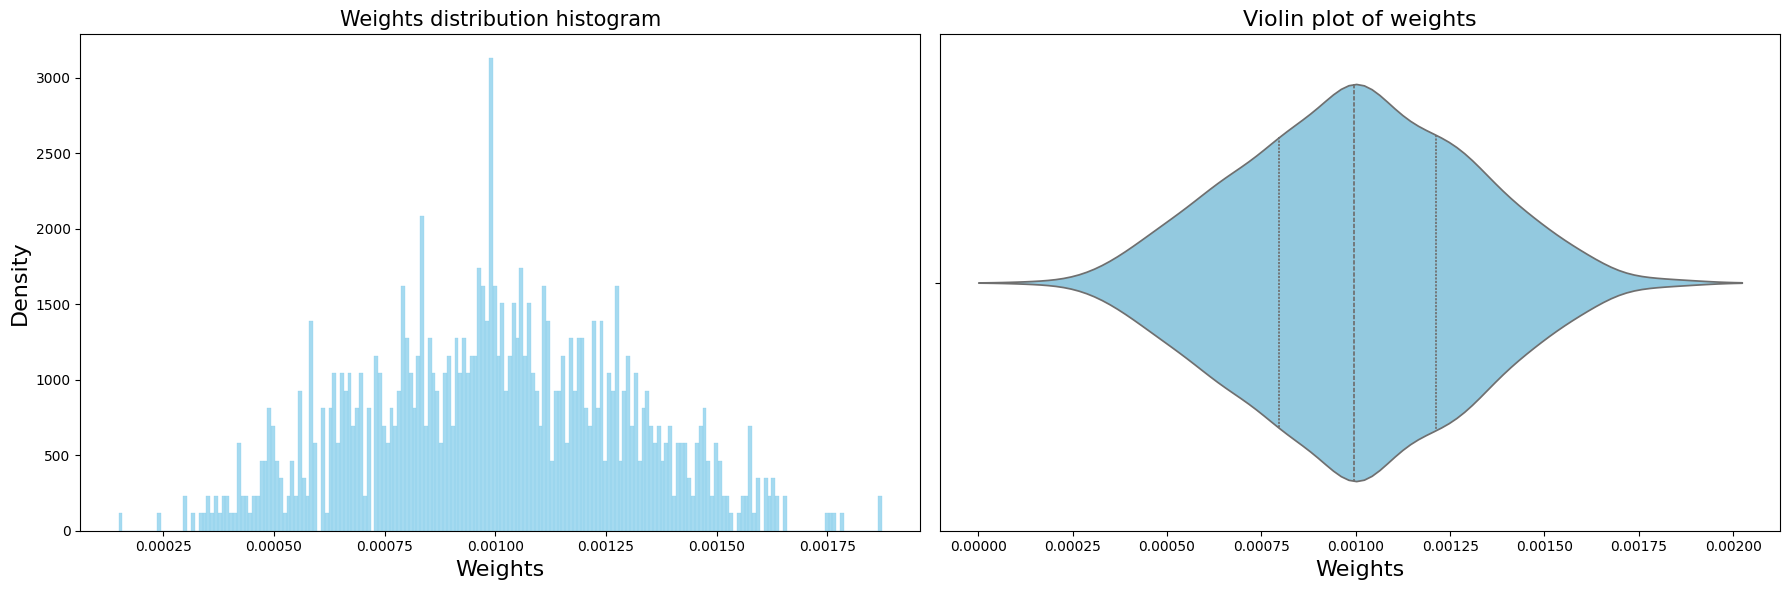

In [9]:
weights = rlwk.weights_
plt.figure(figsize=(18, 6))

# Histogramme
plt.subplot(1, 2, 1)
sns.histplot(weights, bins=200, kde=False, stat='density', color='skyblue', edgecolor='skyblue')
#sns.kdeplot(weights, color='red')
plt.title('Weights distribution histogram', fontsize=15)
plt.xlabel('Weights', fontsize=16)
plt.ylabel('Density', fontsize=16)

# Violin plot
plt.subplot(1, 2, 2)
sns.violinplot(x=weights, inner="quartile", color='skyblue')
plt.title('Violin plot of weights', fontsize=16)
plt.xlabel('Weights', fontsize=16)


# Ajustement des graphiques
plt.tight_layout()
plt.show()



### II. Top terms analysis


In [10]:
def apply_weight(mat, weights, size):
    nb = int(len(weights) * size)
    indices = np.argsort(weights)[:nb]
    new_mat = np.delete(mat, indices, axis=1)

    return new_mat

In [11]:
def custom_preprocessor(text):
    text = re.sub("\\W", " ", text).lower().split()
    lemmatizer = WordNetLemmatizer()

    text = [lemmatizer.lemmatize(word) for word in text]
    
    return ' '.join(word for word in text)

list_of_stop_word = list(ENGLISH_STOP_WORDS)+ ['ha', 'le', 'wa']

In [12]:
## BBC News
data = pd.read_csv('data/Corpus/bbc news/bbc-text.csv') #data['category'].value_counts()
vectorizer = CountVectorizer(preprocessor=custom_preprocessor,
                             stop_words=list_of_stop_word,
                             #tokenizer=LemmaTokenizer,
                             min_df=5,
                            )
mat = vectorizer.fit_transform(data.text)
y = pd.Categorical(data['category']).codes
k = len(set(y))

transformer = TfidfTransformer(norm = 'l2')
mat_tfidf = transformer.fit_transform(mat)


__Fit Rlwk__

In [13]:
n = 1
lamb = 0.0001
alpha = 0
beta = 3
scale = 0
spher = 1
init = 's'

mat = mat_tfidf.toarray()

res_nmi, res_ari = [],[]
for i in range(n):
    print('Iteration',i+1,'/',n,end="\r")
    rlwk = Rlwk(k, lambda_val=lamb, alpha=alpha,beta=beta, spher=spher,scale=scale, init=init)
    rlwk.fit(mat, verbose=False)
    
    res_nmi += [normalized_mutual_info_score(rlwk.labels_,y)]
    res_ari += [adjusted_rand_score(rlwk.labels_,y)]

print(f'\nNMI: {np.mean(res_nmi):.2f} +/- {np.std(res_nmi):.2f} \nARI: {np.mean(res_ari):.2f} +/- {np.std(res_ari):.2f}')

Iteration 1 / 1
NMI: 0.91 +/- 0.00 
ARI: 0.94 +/- 0.00


In [14]:
def top_terms(words, weights, N):
    sorted_indices = sorted(range(len(weights)), key=lambda i: weights[i], reverse=True)  # Trie les indices des termes par poids décroissant
    top_words = [words[i] for i in sorted_indices[:N]]  # Sélectionne les N premiers termes
    top_weights = [weights[i] for i in sorted_indices[:N]]  # Sélectionne les poids correspondants
    
    return dict(zip(top_words, top_weights))

In [15]:
def extract_cluster_matrices(doc_term_matrix, labels):
    labels = np.array(labels)
    cluster_matrices = {}
    for cluster_label in range(len(set(labels))):
        cluster_indices = np.where(labels == cluster_label)[0]
        cluster_matrix = doc_term_matrix[cluster_indices, :]
        cluster_matrices[cluster_label] = cluster_matrix
    return cluster_matrices

__Cluster top terms based on count__

In [16]:
n_features = 10
counts = extract_cluster_matrices(mat_tfidf, rlwk.labels_)
len_terms = len(vectorizer.get_feature_names_out())
for i in range(len(set(rlwk.labels_))):
    count = counts[i].sum(axis=0).tolist()[0]
    weigh_word = sorted(zip(vectorizer.get_feature_names_out(), count), key=lambda x: x[1], reverse=True)
    print(f'\nCluster {i} :\n'+'-'*10)
    for term in weigh_word[:n_features]:
        rank = len_terms-rlwk.get_top_features(vectorizer.get_feature_names_out(), n_features=len_terms).index(term[0])
        print(term[0]+' '+str(round(term[1],2))+' '+str(rank),end=" | ")


Cluster 0 :
----------
mr 36.32 5571 | said 27.27 8131 | labour 26.59 2678 | election 25.7 1819 | party 23.09 1934 | blair 22.51 1863 | tory 19.64 3148 | government 19.08 6983 | minister 17.46 7245 | brown 16.4 1275 | 
Cluster 1 :
----------
game 21.84 2039 | england 17.75 1695 | player 17.08 3664 | win 16.55 5987 | match 15.84 2470 | said 15.28 8131 | team 14.42 3887 | cup 14.18 1761 | club 13.5 902 | final 13.42 2907 | 
Cluster 2 :
----------
said 24.02 8131 | company 18.97 6406 | bank 17.68 631 | firm 17.67 5070 | year 17.27 8117 | growth 16.94 2856 | market 16.91 6079 | economy 16.53 2792 | sale 16.23 1331 | share 15.67 1828 | 
Cluster 3 :
----------
mobile 19.97 494 | people 17.64 7971 | phone 17.6 728 | technology 17.26 5190 | game 17.21 2039 | said 16.8 8131 | user 14.93 2313 | computer 14.0 2481 | service 13.56 3242 | software 12.95 1673 | 
Cluster 4 :
----------
film 37.68 1110 | award 21.59 1002 | best 17.69 2111 | star 14.23 4418 | band 12.4 709 | music 12.09 1200 | said 12

__Cluster top terms based on weights__

In [17]:
n_count = 500
n_weight = 10

df = pd.DataFrame(mat_tfidf.toarray())
df['Cluster'] = rlwk.labels_

# Top terms by count
word_freq_by_cluster = df.groupby('Cluster').sum()
top_terms_count = np.argsort(-word_freq_by_cluster, axis=1)

# Top terms by weight
top_terms = {}

#for cluster, top_words in top_terms_count.items():
for cluster, top_words in enumerate(top_terms_count.values):
    weights = [rlwk.weights_[word] for word in top_words[:n_count]]
    top_terms[cluster] = [top_words[i] for i in np.argsort(np.array(weights))[:n_weight]]

for cluster, top_words in top_terms.items():
    print(f'\n\nCluster {cluster}: \n'+'-'*10)
    for term in top_words:
        rank = len_terms-rlwk.get_top_features(vectorizer.get_feature_names_out(), n_features=len_terms).index(vectorizer.get_feature_names_out()[term])
        score = str(round(word_freq_by_cluster.values[cluster][term],2))
        print(vectorizer.get_feature_names_out()[term],score,rank, end=' | ')



Cluster 0: 
----------
hague 1.96 15 | casino 2.25 18 | bnp 1.88 42 | ukip 5.61 92 | turkey 1.82 96 | hunt 3.38 123 | speaker 2.06 124 | hunting 3.45 125 | muslim 2.43 139 | poster 3.24 172 | 

Cluster 1: 
----------
mirza 2.53 21 | bellamy 2.75 30 | chepkemei 2.25 50 | souness 3.26 61 | conte 2.78 69 | benitez 4.06 77 | villa 2.69 82 | robben 2.22 83 | nadal 2.21 94 | keegan 2.07 100 | 

Cluster 2: 
----------
fiat 4.18 1 | cairn 1.95 14 | barclays 2.24 16 | bmw 2.48 22 | gm 4.79 23 | mci 3.16 28 | parmalat 2.55 29 | marsh 2.98 34 | lending 2.37 37 | mart 2.14 39 | 

Cluster 3: 
----------
domain 4.14 2 | fbi 1.58 5 | robot 2.79 17 | blog 6.08 56 | laser 1.87 64 | linux 2.12 68 | jeeves 1.78 107 | vodafone 2.11 118 | patent 3.33 119 | spyware 4.44 121 | 

Cluster 4: 
----------
stern 1.48 6 | csi 1.78 20 | broadway 1.39 57 | elvis 3.69 71 | presley 2.4 91 | mcfadden 1.49 138 | soul 2.28 183 | vinci 1.4 185 | mtv 2.36 212 | dvd 3.21 229 | 

__R-Lwk top terms__

In [18]:
weigh_word = sorted(zip(vectorizer.get_feature_names_out(), rlwk.weights_), key=lambda x: x[1], reverse=0)
## total tfidf
word_freq_total = df.sum()
rank_tfidf = [word_freq_total[i] for i in np.argsort(rlwk.weights_)[:20]]
## rank top terms
rank_tfidf_weights = [np.where(np.argsort(-word_freq_total) == i) for i in np.argsort(rlwk.weights_)[:20]]
for i in range(20):
    print(weigh_word[i], rank_tfidf[i], rank_tfidf_weights[i][0])

('fiat', 3.262647720578643e-05) 4.182579596992172 [1131]
('domain', 3.587493970916445e-05) 4.141010757638099 [1145]
('bez', 3.6467775756362477e-05) 1.544197233111772 [3172]
('cartridge', 3.701003277669184e-05) 1.4479802246714573 [3353]
('fbi', 3.701118552313885e-05) 2.0524357230921306 [2424]
('stern', 3.7048165250321546e-05) 1.595769887986882 [3086]
('isinbayeva', 3.777140904633409e-05) 1.2365890248098808 [3798]
('lufthansa', 3.79799957465232e-05) 1.3558921151174017 [3530]
('mitsubishi', 3.804755449315721e-05) 1.9501135964519845 [2537]
('virgin', 3.858902504873662e-05) 2.1812014126113066 [2287]
('nissan', 3.9054744604535666e-05) 1.532853974938354 [3189]
('blackpool', 3.9083665358240704e-05) 1.720036705729553 [2891]
('wembley', 3.9146981490970936e-05) 1.4589986536112582 [3334]
('cairn', 3.9303539692119194e-05) 2.25689292061254 [2205]
('hague', 3.939815016845027e-05) 2.102387239614585 [2370]
('barclays', 3.976837005693157e-05) 2.241847554900513 [2221]
('robot', 3.978105953533313e-05) 3.7